# AdaBoost

Let us implement the AdaBoost algorithm, to build a powerful emsemble classifier from a set of weaker classifiers. Our base classifier will be a decision stump.

The training algorithm we will implement is as follows. We have $N$ training datapoints and are creating an ensemble of $k$ classifiers.

- Initialize the weights for all datapoints ($w_j = 1/N$ for $j=1,2,...N$)
- For $i = 1$ to $k$
    - Form training set $D_i$ by sampling $N$ tuples (with replacement) from the full training dataset. The sampling probability for a tuple $(x_j,y_j)$ should be given by its corresponding weight $w_j$.
    - Use dataset $D_i$ to fit a decision stump $M_i$. You can use sklearn's DecisionTreeClassifier with max_depth=1 to fit a decision stump.
    - Calculate the error rate for $M_i$ using the sum of the weights of the misclassified points.
    $$err(M_i) = \sum_{j=1}^N w_j * \mathbb{1}\{y_j \ne M_i(x_j)\}$$
    - The weight of classifier $M_i$'s vote is computed as $\alpha_i = 0.5*\log(\frac{1-err(M_i)}{err(M_i)})$
    - Increase the weight of the misclassified training points, and decrease the weight of the correctly classified training points.
    $$w_j \leftarrow w_j * \exp\{- \alpha_i * y_j * M_i(x_j)\}$$
    - Remember to normalize the weights so that they sum to 1.

In [ ]:
# Import the libraries / functions that you use in your solution
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
import matplotlib as mpl
from sklearn.tree import DecisionTreeClassifier
import random
from math import log

np.random.seed(0)
random.seed(0)

def train_AdaBoost(X, y, k):
    
    classifiers = []
    alphas = []
    
    ### BEGIN SOLUTION
    
    N = X.shape[0]
    D = np.concatenate((X, y.reshape(-1, 1)), axis=1)
    
    # Initialize weights
    sample_weights = np.ones(N) * 1/N
    #sample_weights = = np.array([1/N for i in range(N)])
    for i in range(k):
        
        # Sample from the dataset according to weights 
        D_random_samples = random.choices(D,weights=sample_weights,k=N) #List of arrays is returned
        D_samples = np.vstack(D_random_samples) #List of arrays is converted into single numpy array
        
        # Fit a decision stump 
        clf = DecisionTreeClassifier(criterion = "gini", random_state = 0, max_depth=1)
        X_train = D_samples[:,:-1]
        Y_train = D_samples[:,-1:]
        clf.fit(X_train,Y_train)
        #clf.fit(X_train,Y_train,sample_weights)

        # Calculate the error rate
        Y_pred = clf.predict(D[:,:-1])
        Y_pred = Y_pred.reshape((N, 1)) #Reshape to add one more dimension
        Y = D[:,-1:]

        sample_weights = sample_weights.reshape((N, 1)) #reshape to add one more dimension
        err_m = sum(sample_weights * (np.not_equal(Y, Y_pred)).astype(int))
        
        # Calculate the weight of classifier's vote
        #ipdb.set_trace(context=6)
        alpha_m = 0.5*log((1-err_m)/err_m)
        
        # Increase the weight of misclassified points
        sample_weights = sample_weights * np.exp(-alpha_m * Y * Y_pred)
        sample_weights = sample_weights/sum(sample_weights)
        #sample_weights = round(sample_weights,4)
        
        # Append your classifier to the list classifiers
        classifiers.append(clf)
        
        # Append your alpha to the list alphas
        alphas.append(alpha_m)
        
    ### END SOLUTION
    
    # classifiers and alphas need of be of type <class 'list'>
    return classifiers, alphas

To obtain predictions, the vote of each classifier $M_i$ is weighted by its corresponding coefficient $\alpha_i$.

$$y_i = \text{sign}\{\sum_{i=1}^k \alpha_i*M_i(x_i)\}$$

In [ ]:
def predict_AdaBoost(X,classifiers, alphas):
    
    ### BEGIN SOLUTION
    k = len(classifiers)
    y_pred = np.zeros(X.shape[0])
    for i in range(k):
      y_pred = y_pred + classifiers[i].predict(X) * alphas[i]
    
    signA = np.vectorize(np.sign)
    y_pred = np.where(signA(y_pred)==-1,-1,1)
    
    #classifier_preds = np.array([classifier.predict(X) for classifier in classifiers])
    #y_pred =  np.sign(np.dot(alphas, classifier_preds))
    ### END SOLUTION
    
    # y_pred needs to be of type <class 'numpy.ndarray'>
    return y_pred

The below function will help you plot the decision surface given by the algorithm.

In [ ]:
def plot_AdaBoost(X, y, classifiers, alphas):
    
    # Get limits of x and y for plotting the decision surface
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    
    # Get points at a distance of h between the above limits 
    h = .02    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    temp = np.c_[xx.ravel(), yy.ravel()]
    
    # Classify the all the points
    P = predict_AdaBoost(temp, classifiers, alphas).reshape(yy.shape)
    
    # Plot the decision boundary and margin
    plt.pcolormesh(xx, yy, P, cmap=plt.cm.coolwarm, shading='auto')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm,edgecolor='k')
    plt.show()

**Load** the given datasets.

In [ ]:
drive.mount('/content/drive')
path = '/content/drive/MyDrive/PRML/IITM/Question2/'
X_train = loadtxt(path+'X_train.csv',delimiter=',')
Y_train = loadtxt(path+'y_train.csv',delimiter=',')
X_test = loadtxt(path+'X_test.csv',delimiter=',')
Y_test = loadtxt(path+'y_test.csv',delimiter=',')

Mounted at /content/drive


Plot the training data as a scatter plot.

Text(0, 0.5, '$x_2$')

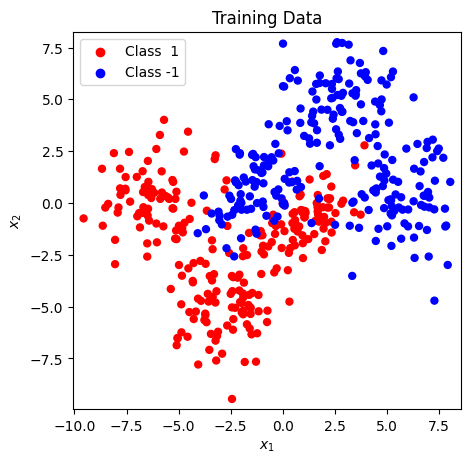

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
fig.set_facecolor('white')
pad = 1
x_min, x_max = X_train[:, 0].min() - pad, X_train[:, 0].max() + pad
y_min, y_max = X_train[:, 1].min() - pad, X_train[:, 1].max() + pad
sizes = np.ones(shape=X_train.shape[0]) * 100

X_pos = X_train[Y_train == 1]
sizes_pos = sizes[Y_train == 1]
ax.scatter(*X_pos.T, s=sizes_pos, marker='.', color='red')

X_neg = X_train[Y_train == -1]
sizes_neg = sizes[Y_train == -1]
ax.scatter(*X_neg.T, s=sizes_neg, marker='.', c='blue')

ax.scatter(0,0, color='red', label='Class  1')
ax.scatter(0,0, color='blue', label='Class -1')
ax.legend(loc='upper left')

ax.set_xlim(x_min+0.5, x_max-0.5)
ax.set_ylim(y_min+0.5, y_max-0.5)

ax.set_title('Training Data')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

Use the train_AdaBoost function to train an AdaBoost model with k=5.

In [ ]:
classifiers_for_k_5, alphas_for_K_5 = train_AdaBoost(X_train, Y_train, k=5)

Use the predict_AdaBoost function to make predictions on X_test.

In [ ]:
y_pred_for_k_5 = predict_AdaBoost(X_test, classifiers_for_k_5, alphas_for_K_5)

Use the plot_AdaBoost function to plot the learnt decision surface on test data


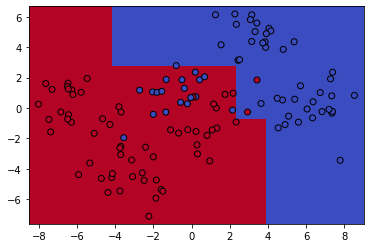

In [ ]:
plot_AdaBoost(X_test,Y_test,classifiers_for_k_5,alphas_for_K_5)

Use the plot_AdaBoost function to plot the learnt decision surface on train data



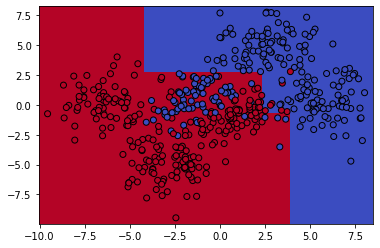

In [ ]:
plot_AdaBoost(X_train,Y_train,classifiers_for_k_5,alphas_for_K_5)

Compute the accuracy of the predictions on the test set.

In [ ]:
print("Test Prediction Accurancy for k=5:",100*sum(y_pred_for_k_5==Y_test)/len(Y_test))

Test Prediction Accurancy for k=5: 83.33333333333333


Use the train_AdaBoost function to train an AdaBoost model with k=100.

In [ ]:
classifiers_for_k_100, alphas_for_K_100 = train_AdaBoost(X_train, Y_train, k=100)

Use the predict_AdaBoost function to make predictions on X_test.

In [ ]:
y_pred_for_k_100 = predict_AdaBoost(X_test, classifiers_for_k_100, alphas_for_K_100)

Use the plot_AdaBoost function to plot the learnt decision surface on test data.


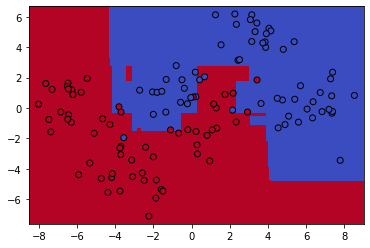

In [ ]:
plot_AdaBoost(X_test,Y_test,classifiers_for_k_100,alphas_for_K_100)

Use the plot_AdaBoost function to plot the learnt decision surface on train data.

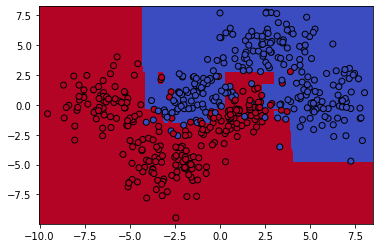

In [ ]:
plot_AdaBoost(X_train,Y_train,classifiers_for_k_100,alphas_for_K_100)

Compute the accuracy of the predictions on the test set.

In [ ]:
print("Test Prediction Accurancy for k=100:",100*sum(y_pred_for_k_100==Y_test)/len(Y_test))

Test Prediction Accurancy for k=100: 91.66666666666667
